# Project Solar

## Data Verkenning

In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

### Zonnepanelen power output dataset
#### Importeren en visualisatie

In [34]:
power = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/solar.csv')
power

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.5400
1,2023-03-11 17:00:10.217795+01,1.0200
2,2023-03-11 18:00:10.284064+01,1.1700
3,2023-03-11 19:00:10.224836+01,1.1800
4,2023-03-11 20:00:10.201847+01,1.1800
...,...,...
9700,2024-04-19 06:00:10.326636+02,2417.3321
9701,2024-04-19 07:00:10.424826+02,2417.3321
9702,2024-04-19 08:00:10.360449+02,2417.3336
9703,2024-04-19 09:00:10.437154+02,2417.3701


In [35]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [36]:
power['timestamp'] = pd.to_datetime(power['timestamp'], utc=True)

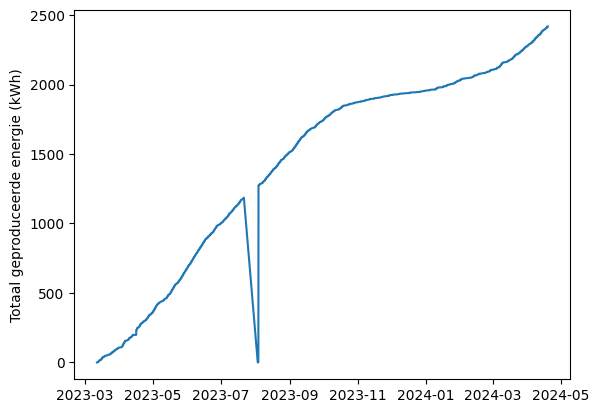

In [41]:
plt.plot(power['timestamp'], power['kwh'])
plt.ylabel('Totaal geproduceerde energie (kWh)')
plt.show()

We zien dat de kwh een cumulatieve meting is, de curve is monotoon stijgend. Er blijkt wel iets misgelopen te zijn in augustus 2023.

#### Onderzoek anomalie

In [38]:
power['kwh_per_hour'] = power['kwh'].diff().fillna(0)

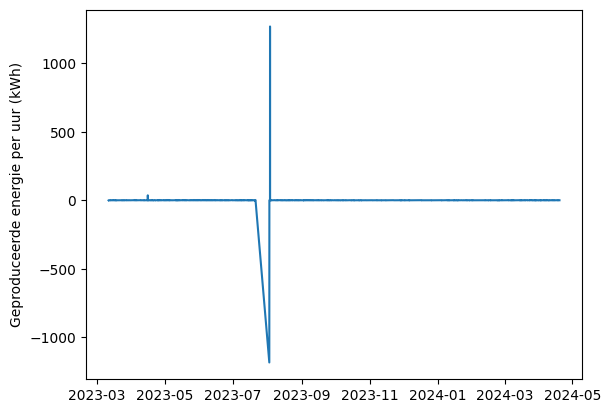

In [64]:
plt.plot(power['timestamp'], power['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

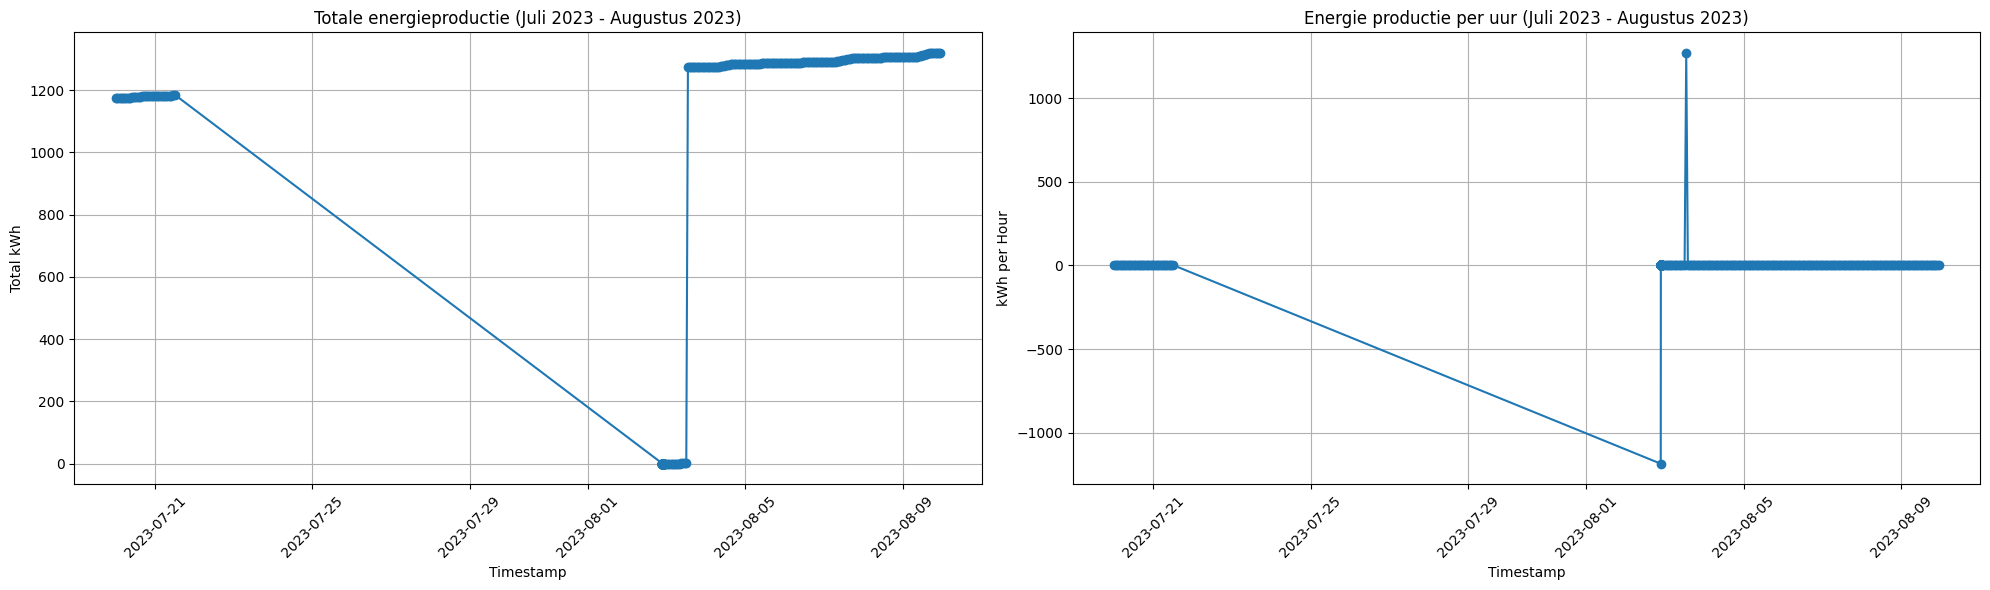

In [67]:
# Define the date range
start_date = pd.Timestamp('2023-07-20', tz='UTC')
end_date = pd.Timestamp('2023-08-10', tz='UTC')

power_augustus = power[(power['timestamp'] >= start_date) & (power['timestamp'] < end_date)]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_augustus['timestamp'], power_augustus['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_augustus['timestamp'], power_augustus['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In de figuur is te zien dat er heel wat waarden ontbreken tussen eind juli en begin augustus. Vervolgens zien we rond 3 augustus dat er gedurende een paar uur de totale energieproductie tot dat punt rond de nul hangt tot het op 1 uur tijd gecorrigeert wordt.

In [73]:
end_of_july = pd.Timestamp('2023-07-31 23:59:59', tz='UTC')
july_data = power[(power['timestamp'] >= start_date) & (power['timestamp'] <= end_of_july)]
last_timestamp_july = july_data['timestamp'].max()
print("Last timestamp in July before the blackout:", last_timestamp_july)

Last timestamp in July before the blackout: 2023-07-21 12:00:11.423424+00:00


In [68]:
power_correcties = power[abs(power['kwh_per_hour']) > 100]
power_correcties

,timestamp,kwh,kwh_per_hour
3166,2023-08-02 21:27:27.552237+00:00,0.0000,-1185.1582
3478,2023-08-03 13:00:12.358859+00:00,1272.9856,1269.9656


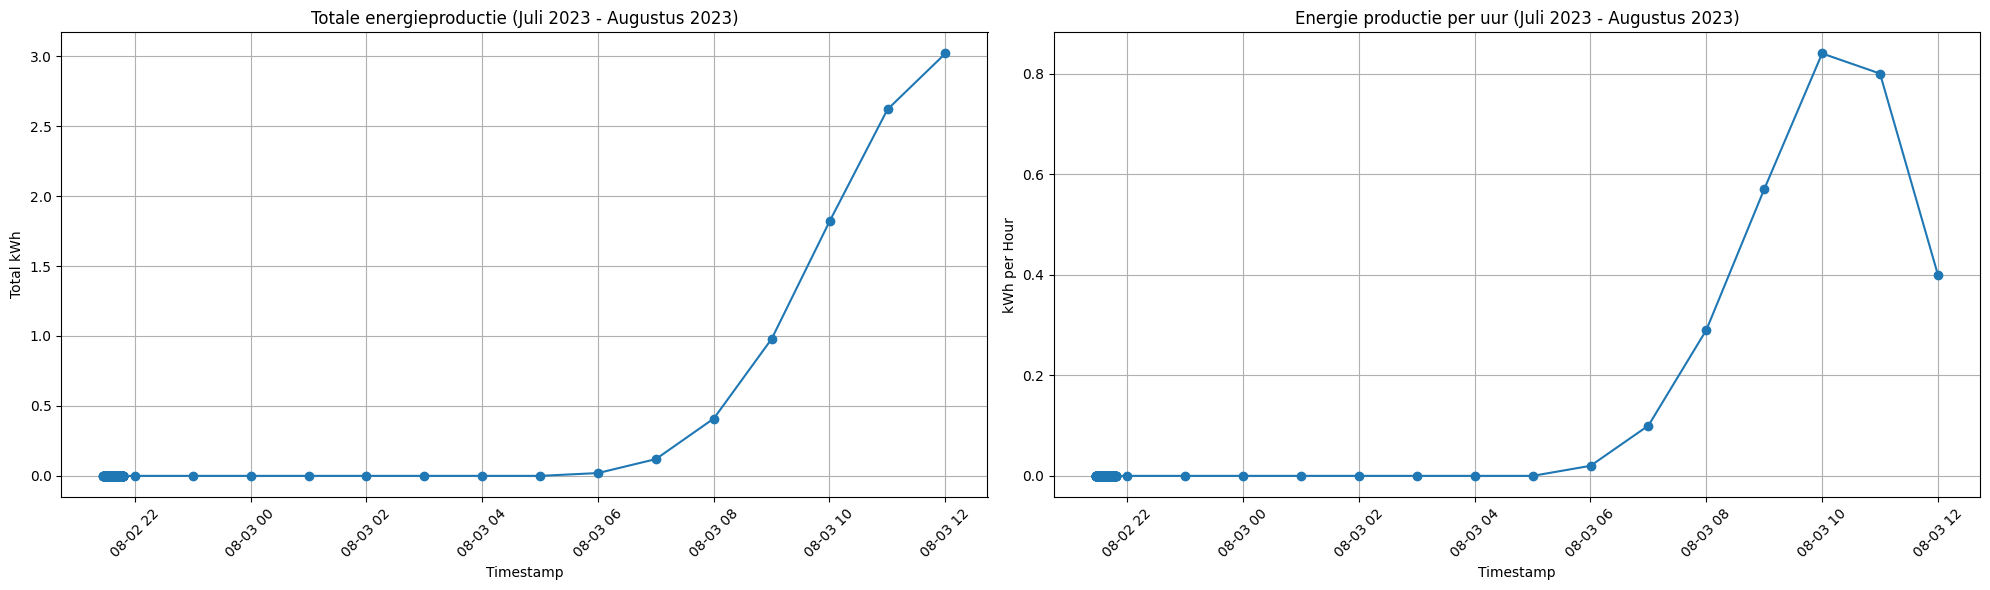

In [71]:
power_anomalie = power[(power['timestamp'] > power_correcties['timestamp'].iloc[0]) & (power['timestamp'] < power_correcties['timestamp'].iloc[-1])]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_anomalie['timestamp'], power_anomalie['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_anomalie['timestamp'], power_anomalie['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Het ziet ernaar uit dat de installatie gestopt is met het registreren van de power input op 2023-07-21 12:00:11.423424+00:00. Op 2023-08-02 21:27:27.552237+00:00, start de installatie terug op en wordt de totale energie productie op 0 gezet. Vervolgens werkt alles normaal voor een paar uur tot op 2023-08-03 13:00:12.358859+00:00 een correctie uitgevoerd wordt naar het echte niveau van de totale energie productie.

### Opkuisen van data

In [74]:
# Foute metingen verwijderen
power_filtered = power[(power['kwh_per_hour'] > 0) & (power['kwh_per_hour'] < 100)]

# Outliers verwijderen
mean = power_filtered['kwh_per_hour'].mean()
std = power_filtered['kwh_per_hour'].std()

power_filtered = power_filtered[(power_filtered['kwh_per_hour'] > mean - 3*std) & (power_filtered['kwh_per_hour'] < mean + 3*std)]


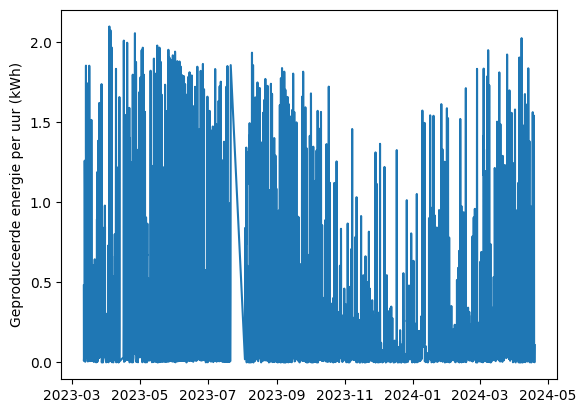

In [85]:
plt.plot(power_filtered['timestamp'], power_filtered['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

In [76]:
power_filtered['date'] = power_filtered['timestamp'].dt.date
daily_output = power_filtered.groupby('date')['kwh_per_hour'].sum().reset_index()
daily_output.columns = ['date', 'daily_kwh']

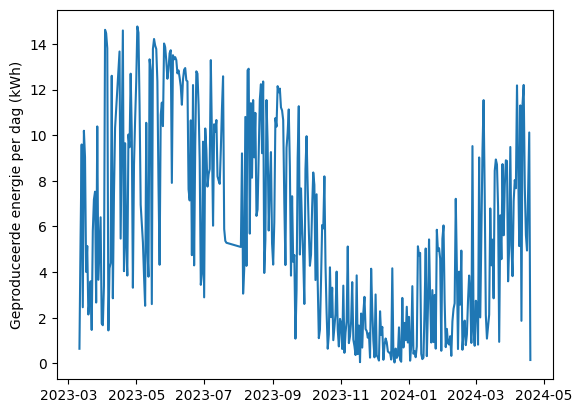

In [82]:
plt.plot(daily_output['date'], daily_output['daily_kwh'])
plt.ylabel('Geproduceerde energie per dag (kWh)')
plt.show()

Hier is duidelijk het effect van de seizoenen zichtbaar in de energieproductie per dag. Rond de zomerzonnewende (21 juni), is er een duidelijke piek in de data. Dit is logisch aangezien dit de dagen zijn met het grootste aantal uren daglicht. Rond de winterzonnewende (21 december), is er dan weer een zichtbaar dal aangezien hier de zon het minste uren per dag schijnt.

### Weerstation dataset
#### Importeren en visualisatie

In [90]:
weather_big = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/weather.csv')
weather_big

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6418.2023-03-01 09:00:00+00,POINT (51.347375 3.201846),6418,2023-03-01T09:00:00,NaN,NaN,4.9,NaN,NaN,NaN,...,1,50.0,9.4,54.3,NaN,1029.7,1028.0,NaN,NaN,0.0
1,synop_data.6414.2023-03-01 09:00:00+00,POINT (50.90398 3.121692),6414,2023-03-01T09:00:00,NaN,NaN,2.1,NaN,NaN,NaN,...,1,44.7,7.5,73.7,NaN,1029.3,1025.9,NaN,NaN,NaN
2,synop_data.6407.2023-03-01 09:00:00+00,POINT (51.200341 2.887306),6407,2023-03-01T09:00:00,NaN,NaN,3.3,NaN,NaN,NaN,...,1,60.0,7.0,NaN,NaN,1029.6,1029.0,NaN,NaN,1.0
3,synop_data.6434.2023-03-01 09:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T09:00:00,NaN,NaN,1.6,NaN,NaN,-10.0,...,1,71.6,5.9,70.9,NaN,1029.4,1027.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 10:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T10:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,1,56.0,7.6,60.8,NaN,1028.8,1026.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,synop_data.6407.2024-04-19 07:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T07:00:00,NaN,NaN,10.6,NaN,NaN,NaN,...,1,290.0,14.0,NaN,NaN,1013.5,1012.8,NaN,NaN,8.0
39836,synop_data.6434.2024-04-19 08:00:00+00,POINT (50.980293 3.816003),6434,2024-04-19T08:00:00,NaN,NaN,10.0,NaN,NaN,NaN,...,1,276.5,9.8,90.5,NaN,1012.7,1010.7,NaN,NaN,NaN
39837,synop_data.6407.2024-04-19 08:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T08:00:00,NaN,NaN,10.8,NaN,NaN,NaN,...,1,290.0,15.0,NaN,NaN,1013.2,1012.6,NaN,NaN,8.0
39838,synop_data.6414.2024-04-19 08:00:00+00,POINT (50.90398 3.121692),6414,2024-04-19T08:00:00,NaN,NaN,9.9,NaN,NaN,NaN,...,1,273.3,12.4,89.7,NaN,1013.6,1010.4,NaN,NaN,NaN


In [91]:
weather_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          39840 non-null  object 
 1   the_geom                     39840 non-null  object 
 2   code                         39840 non-null  int64  
 3   timestamp                    39840 non-null  object 
 4   precip_quantity              6291 non-null   float64
 5   precip_range                 6417 non-null   float64
 6   temp                         39840 non-null  float64
 7   temp_min                     1660 non-null   float64
 8   temp_max                     1657 non-null   float64
 9   temp_grass_min               1189 non-null   float64
 10  wind_speed                   39827 non-null  float64
 11  wind_speed_unit              39840 non-null  int64  
 12  wind_direction               39414 non-null  float64
 13  wind_peak_speed 

In de forecast.csv staan enkel de volgende 5 kolommen: timestamp, temp, pressure, cloudiness, humidity_relative. We houden dus enkel rekening met die kolommen voor het model en verwijderen de overigen.

In [95]:
weather = weather_big[['timestamp', 'temp', 'pressure', 'cloudiness', 'humidity_relative']]
weather

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8
...,...,...,...,...,...
39835,2024-04-19T07:00:00,10.6,1013.5,8.0,NaN
39836,2024-04-19T08:00:00,10.0,1012.7,NaN,90.5
39837,2024-04-19T08:00:00,10.8,1013.2,8.0,NaN
39838,2024-04-19T08:00:00,9.9,1013.6,NaN,89.7


In de documentatie staat volgende informatie voor deze metingen:

- TEMP = air temperature at 1.5m in °C (hourly) 1 value every hour: average measured between (T – 11 min) and (T – 10 min)

- PRESSURE = air pressure at sea level (hPa) (hourly) measured between (T – 11 min) and (T – 10 min)

- CLOUDINESS = part of the sky covered in clouds (in octas) instantaneous

- HUMIDITY_RELATIVE = relative humidity of the air in % (hourly) average RH measured/calculated between (T – 11 min) and (T – 10 min)

We zien hier dat cloudiness een classificatie is met 8 mogelijkheden. Het zijn wel waarden die op elkaar volgen dus het is morgelijk om een OrdinalEncoder te gebruiken.

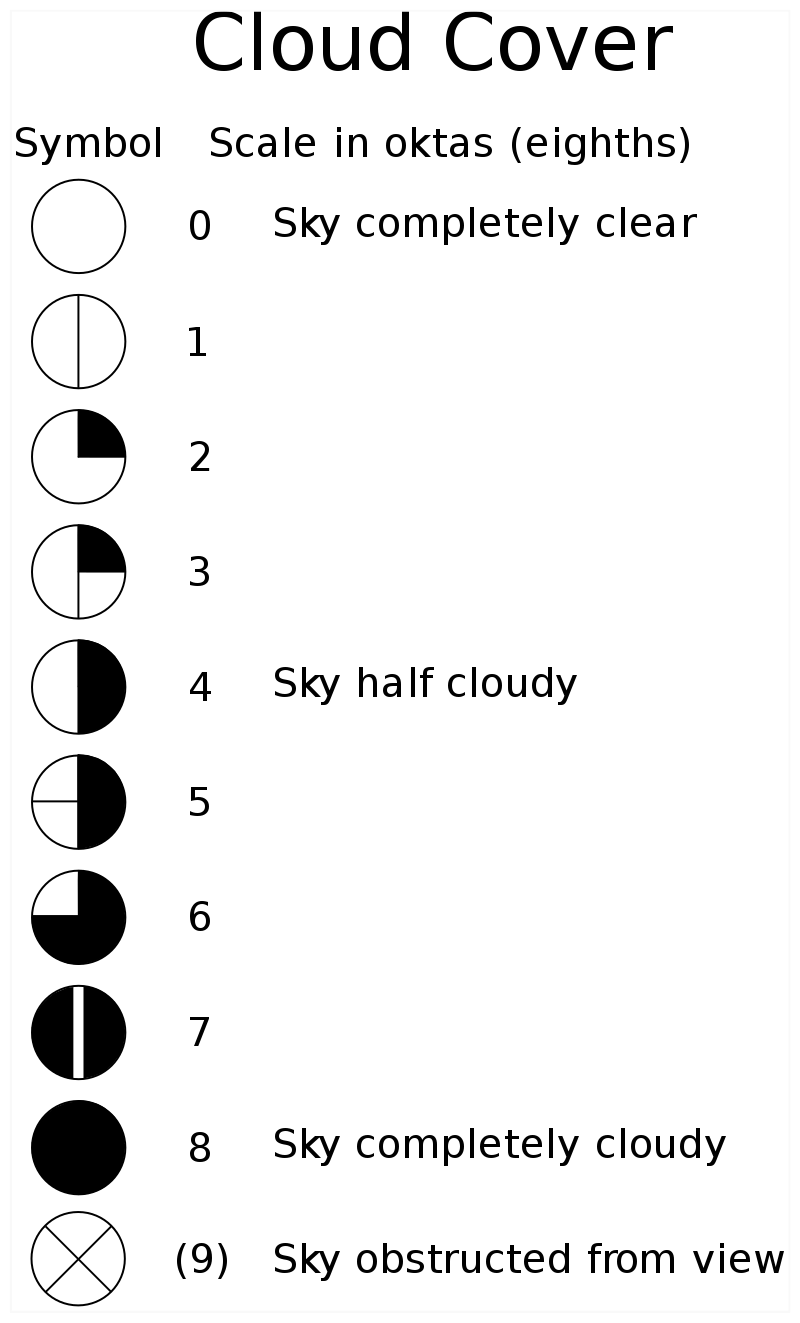

In [101]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

C:\Users\robin\AppData\Local\Temp\ipykernel_23356\2077539338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['timestamp'] = pd.to_datetime(weather['timestamp'])


In [99]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          39840 non-null  datetime64[ns, UTC]
 1   temp               39840 non-null  float64            
 2   pressure           39828 non-null  float64            
 3   cloudiness         15455 non-null  float64            
 4   humidity_relative  29880 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 1.5 MB


Uit het overzicht blijkt dat timestamp en temperatuur altijd ingevuld zijn er enkele ontbrekende waarden zijn bij pressure en dat er bij cloudiness en relative humidity vaak waarden ontbreken. 

In [100]:
weather.describe()

,temp,pressure,cloudiness,humidity_relative
count,39840.000000,39828.000000,15455.000000,29880.000000
mean,11.857083,1013.377732,5.490780,81.043618
std,5.858675,11.320142,2.583189,13.898511
min,-5.900000,965.100000,0.000000,24.700000
25%,8.200000,1007.200000,4.000000,72.500000
50%,11.200000,1014.700000,7.000000,84.200000
75%,15.900000,1021.200000,7.000000,92.000000
max,32.400000,1041.800000,8.000000,100.000000


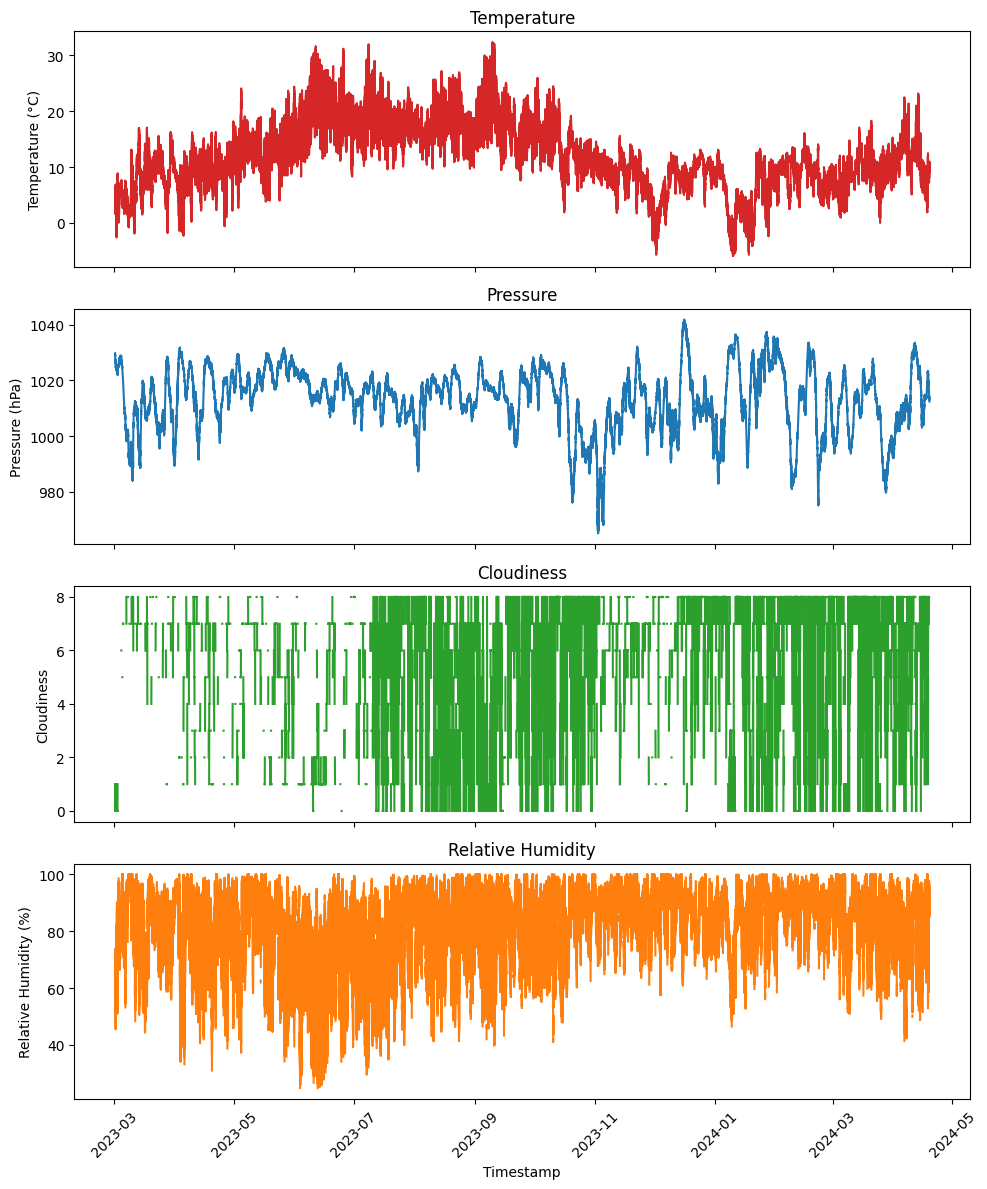

In [102]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(weather['timestamp'], weather['temp'], color='tab:red')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')

axs[1].plot(weather['timestamp'], weather['pressure'], color='tab:blue')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')

axs[2].plot(weather['timestamp'], weather['cloudiness'], color='tab:green')
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')

axs[3].plot(weather['timestamp'], weather['humidity_relative'], color='tab:orange')
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')

# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er zijn enkele logische trends zichtbaar in de data:

- Temperature: In de zomermaanden is het gemiddeld warmer dan in de wintermaanden
- Pressure: In het najaar lijkt de luchtdruk een pak stabieler dan in het voorjaar.
- Cloudiness: Tijdens de herfst en lente is het significant meer bewolkt dan tijdens de zomer en winter.
- Relative humidity: De relatieve luchtvochtigheid is behoorlijk constant al is er een duidelijk dip merkbaar rond juni en juli.

### Zonsondergang dataset
#### Importeren en visualisatie

In [110]:
sunset = pd.read_excel('https://github.com/HOGENT-ML/course/raw/main/datasets/sunrise-sunset.xlsx')
sunset

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00
...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00


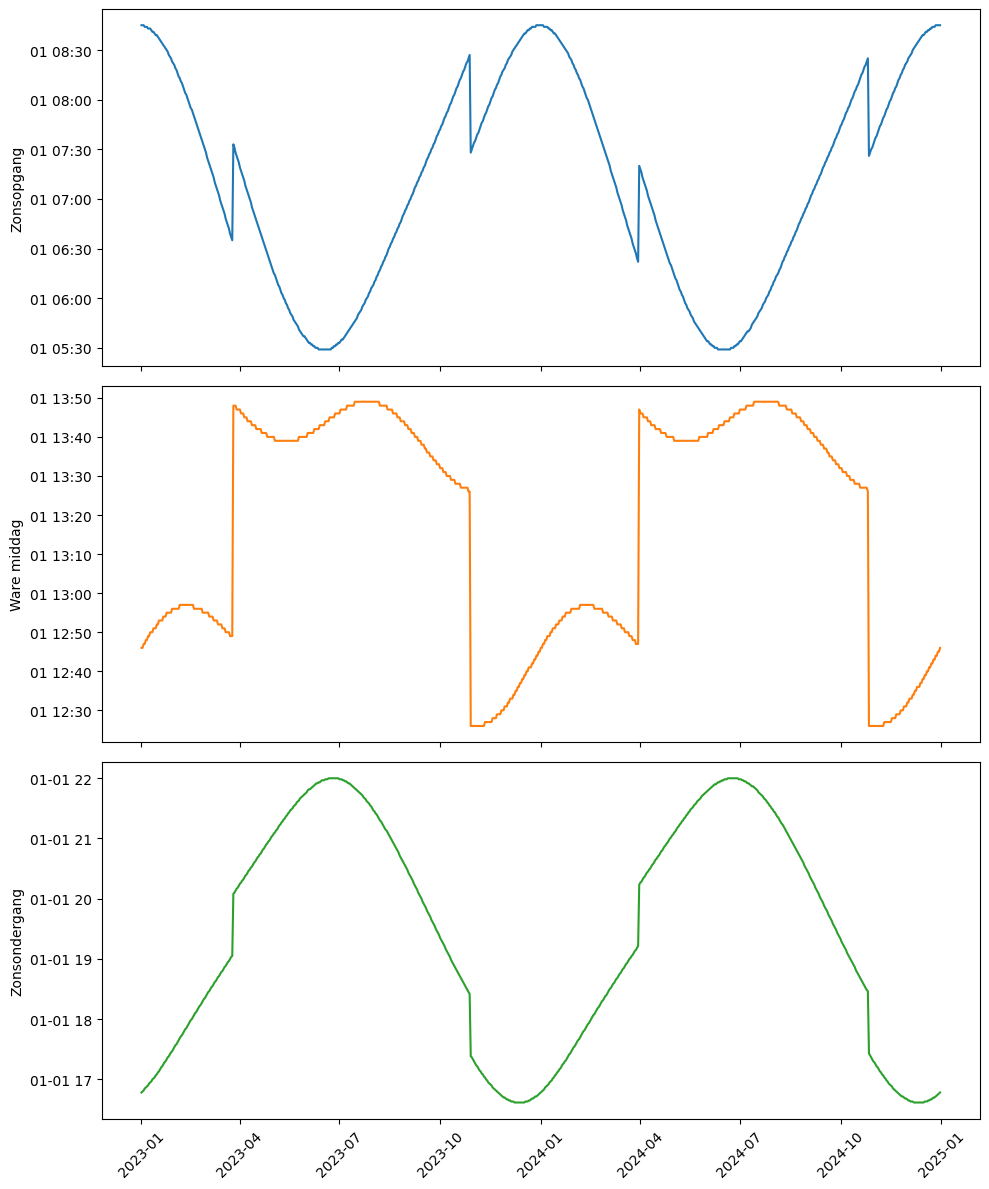

In [111]:
# Convert time columns to datetime objects
sunset['datum'] = pd.to_datetime(sunset['datum'], format='%Y-%m-%d')
sunset['Opkomst'] = pd.to_datetime(sunset['Opkomst'], format='%H:%M:%S')
sunset['Op ware middag'] = pd.to_datetime(sunset['Op ware middag'], format='%H:%M:%S')
sunset['Ondergang'] = pd.to_datetime(sunset['Ondergang'], format='%H:%M:%S')

# Create subplots for each column
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(sunset['datum'], sunset['Opkomst'], color='tab:blue')
axs[0].set_ylabel('Zonsopgang')

axs[1].plot(sunset['datum'], sunset['Op ware middag'], color='tab:orange')
axs[1].set_ylabel('Ware middag')

axs[2].plot(sunset['datum'], sunset['Ondergang'], color='tab:green')
axs[2].set_ylabel('Zonsondergang')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er is een periodiciteit zichtbaar in elke kolom. Het is eveneens duidelijk dat deze natuurlijke fenomenen normaal een sinusoidaal verloop hebben, echter wordt dit op vaste momenten verschoven door de overgangen van winter- en zomeruur.

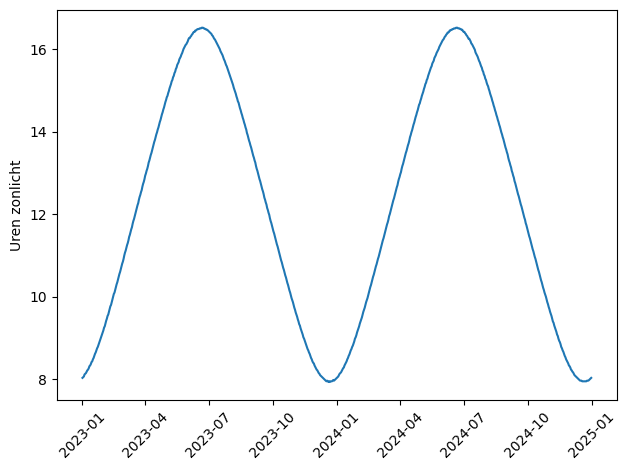

In [117]:
sunset['Uren zonlicht'] = (sunset['Ondergang'] - sunset['Opkomst']).dt.total_seconds() / 3600
plt.plot(sunset['datum'], sunset['Uren zonlicht'])
plt.ylabel('Uren zonlicht')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()